In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
import torch.nn.init as init
from torchsummary import summary

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging

import pickle 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

# Loss

In [2]:
maeLoss = nn.L1Loss()

# QC U-Net


In [3]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_pool, x_conv

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = nn.Sequential(
            nn.BatchNorm2d(out_channels + skip_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.block(x)

class QCUNet(nn.Module):
    def __init__(self, in_channels=2):
        super(QCUNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 40)
        self.enc2 = EncoderBlock(40, 40)
        self.enc3 = EncoderBlock(40, 80)
        self.enc4 = EncoderBlock(80, 160)
        self.enc5 = EncoderBlock(160, 320)

        self.bottleneck = ConvBlock(320, 640)

        self.dec5 = DecoderBlock(640, 320, 320)
        self.dec4 = DecoderBlock(320, 160, 160)
        self.dec3 = DecoderBlock(160, 80, 80)
        self.dec2 = DecoderBlock(80, 40, 40)
        self.dec1 = DecoderBlock(40, 40, 40)

        self.output_conv = nn.Conv2d(40, 1, kernel_size=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Outputs shape (B, 1, 1, 1)

    def forward(self, x):
        x1_pool, x1 = self.enc1(x)
        x2_pool, x2 = self.enc2(x1_pool)
        x3_pool, x3 = self.enc3(x2_pool)
        x4_pool, x4 = self.enc4(x3_pool)
        x5_pool, x5 = self.enc5(x4_pool)

        x = self.bottleneck(x5_pool)

        x = self.dec5(x, x5)
        x = self.dec4(x, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        x = self.output_conv(x)                    # (B, 1, H, W)
        x = self.global_avg_pool(x)                # (B, 1, 1, 1)
        return x.view(x.size(0), -1)               # Flatten to shape (B, 1)


In [8]:
model = model.to(device)
summary(model, (2, 256, 256))

NameError: name 'model' is not defined

# Try overfitting to check that it works

In [13]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
from pathlib import Path

class QCDataset(Dataset):
    def __init__(self, qc_dir, ct_dir):
        self.qc_dir = Path(qc_dir)
        self.ct_dir = Path(ct_dir)

        # Load CSV containing metadata (case, slice, dsc)
        self.data = pd.read_csv(self.qc_dir / "results.csv")  # <--- FIXED: 'self.qcData' → 'self.data'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        case_number = int(row['case'])
        slice_idx = int(row['slice'])
        dsc = float(row['dsc'])

        # Load predicted segmentation
        seg_path = self.qc_dir / f"{case_number}_slice_{slice_idx}_pred.npy"
        seg = np.load(seg_path).astype(np.float32)

        # Load CT slice
        ct_path = self.ct_dir / f"volume-{case_number}.npy"
        ct = np.load(ct_path)[:, :, slice_idx]  # shape: [H, W]
        ct_image = Image.fromarray(ct).convert("F")
        ct_image = TF.resize(ct_image, (256, 256))
        ct_resized = np.array(ct_image, dtype=np.float32)

        # Stack CT and prediction
        X = np.stack([ct_resized, seg], axis=0)  # shape: [2, 256, 256]
        X_tensor = torch.tensor(X)

        return X_tensor, torch.tensor(dsc, dtype=torch.float32), case_number, slice_idx


In [ ]:
class CTOrganSegDataset(Dataset):
    def __init__(self, case_numbers, dir, filteredData=Path("kidneySlices.pkl")):
        self.case_numbers = case_numbers
        self.data_dir = Path(dir)
        self.resize_size = (256, 256)

        # Load precomputed slice data
        with open(filteredData, 'rb') as f:
            all_slice_data = pickle.load(f)

        # Keep only slices for relevant cases
        self.slice_data = [
            (case_number, slice_idx)
            for (case_number, slice_idx) in all_slice_data
            if case_number in self.case_numbers
        ]

        # Preload volume and label paths
        self.volumePaths = {
            case_number: self.data_dir / f"volume-{case_number}.npy"
            for case_number in self.case_numbers
        }
        self.labelPaths = {
            case_number: self.data_dir / f"labels-{case_number}.npy"
            for case_number in self.case_numbers
        }

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):
        case_number, slice_idx = self.slice_data[idx]
        volume = np.load(self.volumePaths[case_number])
        label = np.load(self.labelPaths[case_number])

        volume_slice = volume[:, :, slice_idx]
        label_slice = label[:, :, slice_idx]

        # Resize CT slice
        volume_pil = Image.fromarray(volume_slice).convert("F")
        volume_resized = TF.resize(volume_pil, self.resize_size)
        volume_array = np.array(volume_resized, dtype=np.float32)

        # Determine which class to segment
        target_class = 4
        binary_mask = (label_slice == target_class).astype(np.uint8)

        # Resize mask
        mask_pil = Image.fromarray(binary_mask * 255)
        mask_resized = TF.resize(mask_pil, self.resize_size)
        mask_array = np.array(mask_resized) / 255.0

        # Stack input and mask
        X = np.stack([volume_array, mask_array], axis=0).astype(np.float32)

        return torch.tensor(X), case_number, slice_idx


In [4]:
qc_dir = Path( "/work3/kvabo/predictions/qcLiverDsc0.7")
df = pd.read_csv(Path( "/work3/kvabo/predictions/qcLiverDsc0.7/results.csv"))
case0 = df[(df["case"] == 0)]

### Calculate the MVSF 
The MVSF takes values in the range $[-2, 2]$. Since our neural network uses a sigmoid activation at the output, we normalize the MVSF to the interval $[0, 1]$ during training. Specifically, we store the normalized value in the CSV file as:

$\text{MVSF}_{\text{normalized}} = \frac{\text{MVSF} + 2}{4}$

This makes the target compatible with the sigmoid output and simplifies data loading. When the original MVSF value is needed (e.g., for estimating the 3D DSC), it can be recovered from the predicted normalized value using:

$
\text{MVSF} = 4 \cdot \text{pred} - 2
$

In [44]:
case0

,case,slice,model,dsc,prediction_file
0,0,45,qcLiverDsc0.7,0.31842,0_slice_45_pred.npy
1,0,46,qcLiverDsc0.7,0.57035,0_slice_46_pred.npy
2,0,47,qcLiverDsc0.7,0.52927,0_slice_47_pred.npy
3,0,48,qcLiverDsc0.7,0.59340,0_slice_48_pred.npy
4,0,49,qcLiverDsc0.7,0.69461,0_slice_49_pred.npy
5,0,50,qcLiverDsc0.7,0.75177,0_slice_50_pred.npy
6,0,51,qcLiverDsc0.7,0.78395,0_slice_51_pred.npy
7,0,52,qcLiverDsc0.7,0.84579,0_slice_52_pred.npy
8,0,53,qcLiverDsc0.7,0.86940,0_slice_53_pred.npy
9,0,54,qcLiverDsc0.7,0.84434,0_slice_54_pred.npy


In [23]:
case0[case0['slice'] == 45]

,case,slice,model,dsc,prediction_file
0,0,45,qcLiverDsc0.7,0.31842,0_slice_45_pred.npy


In [11]:
np.ones((3,3,3)).flatten()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
Y = np.ones((3,3)).flatten()
Z = np.zeros((3,3)).flatten()
Z[2] = 1

np.sum(Y*Z)

1.0

In [34]:
def DSC(Y, Z):
    # Y nSlicesx256x256
    Y = Y.flatten()
    Z = Z.flatten()
    # numerator 
    num = 2*np.sum(Y*Z)

    # denominator 
    denom = np.sum(Y) + np.sum(Z)

    return num/denom
    
    

def MVSF(Y,Z):
    Y = np.sum(Y.flatten())
    Z = np.sum(Z.flatten())

    # numerator
    num = 2*(Y - Z)

    # denominator
    denom = Y + Z

    return num/denom

In [51]:
gtSeg0.shape[2]

75

In [40]:
gtSeg0 = np.load(dir / f"labels-{0}.npy").astype(np.uint8)
target_class = 1
ct_path = dir / f"volume-{0}.npy"
Z = []
YHat = []
YZHat = []
for slice in case0['slice']:
    gtSegslice = gtSeg0[:, :, slice]
    binary_mask = (gtSegslice == target_class).astype(np.uint8)
    
    # Resize mask
    mask_pil = Image.fromarray(binary_mask * 255)
    mask_resized = TF.resize(mask_pil, (256, 256))
    mask_array = np.array(mask_resized) / 255.0

    dsc = case0[case0['slice'] == slice]['dsc']

    # Load predicted segmentation
    seg_path = qc_dir / f"{0}_slice_{slice}_pred.npy"
    seg = np.load(seg_path).astype(np.float32)

    # Load CT slice
    
    ct = np.load(ct_path)[:, :, slice]  # shape: [H, W]
    ct_image = Image.fromarray(ct).convert("F")
    ct_image = TF.resize(ct_image, (256, 256))
    ct_resized = np.array(ct_image, dtype=np.float32)

    dice = DSC(mask_array,seg)
    mvsf = MVSF(mask_array,seg)
    z = np.sum(seg.flatten())
    yHat = z*(2+mvsf)/(2-mvsf)
    yzHat = 0.5*dsc*(yHat + z)

    Z.append(z)
    YHat.append(yHat)
    YZHat.append(yzHat)

In [87]:
qc_dir = Path( "/work3/kvabo/predictions/qcKidneyDsc1.0")
targetClass = 4
df = pd.read_csv(qc_dir /"results.csv")
case0 = df[(df["case"] == 0)]
gtSeg0 = np.load(dir / f"labels-{0}.npy").astype(np.uint8)

ct_path = dir / f"volume-{0}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)

for slice in case0['slice']:
 
    # Load predicted segmentation
    seg_path = qc_dir / f"{0}_slice_{slice}_pred.npy"
    seg = np.load(seg_path).astype(np.float32)

    # Resize to (512, 512)
    seg_image = Image.fromarray((seg * 255).astype(np.uint8))  # convert to image
    seg_resized = TF.resize(seg_image, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)

    # Convert back to NumPy and binarize if needed
    seg_resized_array = np.array(seg_resized).astype(np.uint8) // 255  # back to [0, 1]
    # Set class label
    pred[:, :, slice] = seg_resized_array * target_class
    #pred[:, :,slice] = seg*targetClass



In [92]:
kidneySlices["slice"]

0     34
1     35
2     36
3     37
4     38
5     39
6     40
7     41
8     42
9     43
10    44
11    45
12    46
13    47
14    48
15    49
16    50
17    51
18    52
19    53
20    54
21    55
22    56
23    57
Name: slice, dtype: int64

In [104]:
nCase = 0

qcDirKidney = Path( "/work3/kvabo/predictions/qcKidneyDsc0.4")
qcDirLiver = Path( "/work3/kvabo/predictions/qcLiverDsc0.4")

dfKidney = pd.read_csv(qcDirKidney /"results.csv")
dfLiver = pd.read_csv(qcDirLiver /"results.csv")

kidneySlices = dfKidney[(dfKidney["case"] == nCase )]
liverSlices = dfLiver[(dfLiver["case"] == nCase )]



gtSeg0 = np.load(dir / f"labels-{0}.npy").astype(np.uint8)

ct_path = dir / f"volume-{0}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)

for slice in range(n_total_slices):
    kidneyMask = np.zeros((512, 512), dtype=np.uint8)
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in kidneySlices["slice"].values:
        # Load predicted segmentation
        segPathKidney = qcDirKidney / f"{0}_slice_{slice}_pred.npy"
        segKidney = np.load(segPathKidney).astype(np.float32)
    
        # Resize to (512, 512)
        segKidney = Image.fromarray((segKidney * 255).astype(np.uint8))  # convert to image
        segKidney = TF.resize(segKidney, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segKidney = np.array(segKidney).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        kidneyMask = segKidney 

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{0}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver
    # Zero out overlapping pixels
    overlap = (kidneyMask == 1) & (liverMask == 1)
    kidneyMask[overlap] = 0
    liverMask[overlap] = 0

    # Assign class labels
    pred[:, :, slice] = kidneyMask * 4 + liverMask  # kidney=4, liver=1


In [106]:
nii_path = "/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-0.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), "pred.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")

In [69]:
import nibabel as nib

# Load the original NIfTI file
nii_path = "/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-0.nii.gz"
nii = nib.load(nii_path)

# Check the shape
print("Shape:", nii.shape)

# Check the voxel spacing (pixel dimensions)
print("Voxel spacing:", nii.header.get_zooms())

# Check the affine matrix (position and orientation in space)
print("Affine matrix:\n", nii.affine)

# Optional: data type
print("Data type:", nii.get_data_dtype())


Shape: (512, 512, 75)
Voxel spacing: (0.703125, 0.703125, 5.0)
Affine matrix:
 [[  -0.703125     0.           0.         172.8999939]
 [   0.           0.703125     0.        -179.296875 ]
 [   0.           0.           5.        -368.       ]
 [   0.           0.           0.           1.       ]]
Data type: int16


In [21]:
case_id = 0
target_class = 1
case0 = pd.read_csv(qc_dir / "results.csv")
case0 = case0[case0['case'] == case_id]

# Load full label and CT volumes
gt_volume = np.load(dir / f"labels-{case_id}.npy").astype(np.uint8)
ct_volume = np.load(dir / f"volume-{case_id}.npy").astype(np.float32)

# Output lists
gt_masks = []
pred_masks = []
ct_slices = []


# Loop over selected slices
for slice_idx in case0['slice']:
    # Ground truth mask for the target class
    gt_slice = gt_volume[:, :, slice_idx]
    binary_mask = (gt_slice == target_class).astype(np.uint8)
    mask_resized = TF.resize(Image.fromarray(binary_mask * 255), (256, 256))
    mask_array = np.array(mask_resized) / 255.0  # convert to float32 mask
    gt_masks.append(mask_array.astype(np.uint8))

    # Predicted segmentation
    seg_path = qc_dir / f"{case_id}_slice_{slice_idx}_pred.npy"
    pred_mask = np.load(seg_path)
    pred_masks.append(pred_mask)

    # CT slice
    ct_slice = ct_volume[:, :, slice_idx]
    ct_resized = TF.resize(Image.fromarray(ct_slice).convert("F"), (256, 256))
    ct_array = np.array(ct_resized, dtype=np.float32)
    ct_slices.append(ct_array)


# Optional: convert to arrays
gt_masks = np.stack(gt_masks)           # (N, 256, 256)
pred_masks = np.stack(pred_masks)       # (N, 256, 256)
ct_slices = np.stack(ct_slices)         # (N, 256, 256)


In [23]:
dsc3D(gt_masks, pred_masks)

0.7874422113779376

In [24]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Load full dataset
full_dataset = QCKidneyDataset("/work3/kvabo/predictions/qcLiverDsc0.5", dir)

# Convert to DataFrame for filtering
full_df = full_dataset.data

# Get indices for test and train based on case numbers
test_indices = full_df.index[full_df['case'].between(1, 21)].tolist()
train_indices = full_df.index[full_df['case'].between(22, 140)].tolist()

# Create Subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True,persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=False,persistent_workers=True)


In [25]:
for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(test_loader):
    print(dsc)
    print(case_ids)

tensor([0.0018, 0.1177, 0.2498, 0.3952, 0.5546])
tensor([1, 1, 1, 1, 1])
tensor([0.6424, 0.6306, 0.6282, 0.6248, 0.6197])
tensor([1, 1, 1, 1, 1])
tensor([0.5874, 0.5655, 0.5746, 0.4988, 0.5059])
tensor([1, 1, 1, 1, 1])
tensor([0.4834, 0.4766, 0.5210, 0.5493, 0.5592])
tensor([1, 1, 1, 1, 1])
tensor([0.5473, 0.5387, 0.5116, 0.5162, 0.5218])
tensor([1, 1, 1, 1, 1])
tensor([0.5726, 0.5148, 0.4717, 0.0265, 0.0098])
tensor([1, 1, 1, 1, 2])


KeyboardInterrupt: 

In [26]:
model = QCUNet()

def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)


# Training loop
model.train()
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(train_loader):
        X = X.to(device)
        dsc = dsc.to(device)

        opt.zero_grad()
        outputs = model(X)  # Regression: output shape [batch_size, 1]
        pred_dsc = torch.sigmoid(outputs).squeeze()

        loss = maeLoss(pred_dsc, dsc)
        print(loss)
        loss.backward()
        opt.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

tensor(0.3489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2658, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2736, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2548, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1618, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2705, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2164, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1351, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0732, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0945, device='cuda:0',

KeyboardInterrupt: 

In [10]:
diceLoss = smp.losses.DiceLoss(mode='binary', from_logits=False, eps=1e-7, smooth = 1)

In [30]:
a=np.ones((4,2))
#a =np.flatten(a)
np.sum(a)

8.0

In [27]:
target_class =4
def mvsf(pred, gt):
    y = np.sum(gt)
    z = np.sum(pred)
    mvsf = 2*(y-z)/(y+z)
    return mvsf

for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(test_loader):
    print(dsc, case_ids, slice_indices)
    print(batch_idx)

    if epoch == 0 and batch_idx == 1:
        # Display CT slice and predicted segmentation
        plt.imshow(X[4][0].cpu().numpy(), cmap='gray')
        plt.title("CT Slice")
        plt.show()

        pred_seg = X[4][1].cpu().numpy()
        plt.imshow(pred_seg, cmap='gray')
        plt.title("Predicted Segmentation")
        plt.show()

        # Load and process ground truth
        gt_path = dir / f"labels-{case_ids[4]}.npy"
        gt_full = np.load(gt_path)  # shape [H, W, D]
        gt = (gt_full[:, :, slice_indices[4]] == target_class).astype(np.uint8)

        # Resize to match prediction size if needed
        gt_tensor = torch.tensor(gt).unsqueeze(0).float()
        gt_resized = TF.resize(gt_tensor, (256, 256)).squeeze().numpy().astype(np.uint8)

        plt.imshow(gt_resized, cmap='gray')
        plt.title("Ground Truth Segmentation")
        plt.show()

        print("DSC:", dsc[4])
        # Compute MVSF
        mv_score = mvsf(pred_seg, gt_resized)
        print("MVSF:", mv_score)

        

RuntimeError: DataLoader worker (pid(s) 1553980, 1554005, 1554029, 1554053, 1554077, 1554101, 1554125, 1554149) exited unexpectedly

In [30]:
model.eval()  # Set eval mode once
target_class =4
for epoch in range(num_epochs):
    running_loss = 0.0

    with torch.no_grad():  # Disable grad tracking
        for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(test_loader):
            print(dsc, case_ids, slice_indices)
            X = X.to(device)
            dsc = dsc.to(device)
            
            outputs = model(X)
            pred_dsc = torch.sigmoid(outputs).squeeze()
            print(pred_dsc)
            print(dsc)

            loss = maeLoss(pred_dsc, dsc)
            running_loss += loss.item()

            # Optional: plot only first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(X[4][1].cpu().shape)
                plt.imshow(X[4][0].cpu().numpy(), cmap='gray')
                plt.title("CT Slice")
                plt.show()
                plt.imshow(X[4][1].cpu().numpy(), cmap='gray')
                plt.title("Predicted Segmentation")
                plt.show()
                gt_path = dir / f"labels-{case_ids[4]}.npy"
                gt = (np.load(gt_path)[:, :, slice_indices[4]] == target_class).astype(np.uint8)  # shape: [H, W]
                gt_tensor = torch.tensor(gt).unsqueeze(0).float()  # shape [1, H, W]
                gt_resized = TF.resize(gt_tensor, (256, 256))
                plt.imshow(gt, cmap='gray')
                plt.show()
                print(dsc[4])
                print(1- diceLoss(X[4][1].cpu().unsqueeze(0),gt_resized))
        break
    avg_loss = running_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_loss:.4f}")

RuntimeError: DataLoader worker (pid(s) 1553980, 1554005, 1554029, 1554053, 1554077, 1554101, 1554125, 1554149) exited unexpectedly

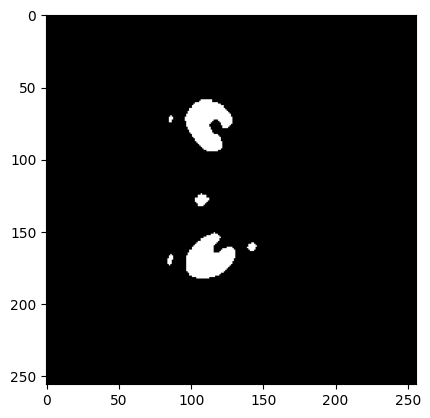

In [122]:
plt.imshow(X[0][1].detach().cpu().numpy(),cmap='gray')

In [15]:
qcData = pd.read_csv("../predictions")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc

FileNotFoundError: [Errno 2] No such file or directory: '../predictions/qcKidneyDsc0.5Continued/results.csv'

In [93]:
qcData = pd.read_csv("predictions/qcKidneyDsc1.0/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
n = 0
segPath = Path(f"predictions/qcKidneyDsc1.0/{case_number[n]}_slice_{slice_idx[n]}_pred.npy")
seg = np.load(segPath)
ctPath = dir / f"volume-{case_number[n]}.npy"
ct = np.load(ctPath)[:,:,slice_idx[n]]

# Resize CT slice
ct = Image.fromarray(ct).convert("F")
ct = TF.resize(ct, (256,256))
ct = np.array(ct, dtype=np.float32)

X = np.stack([ct, seg], axis=0).astype(np.float32)
X = torch.tensor(X).unsqueeze(0)

In [110]:
model = QCUNet()

def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)

model.train()
num_epochs = 80

X = X.to(device)
dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)

for epoch in range(num_epochs):
    opt.zero_grad()
    outputs = model(X)
    predDSC = torch.sigmoid(outputs)
    loss = maeLoss(predDSC, dsc_tensor)
    loss.backward()
    opt.step()
    scheduler.step()
    print(f"Epoch {epoch}: Loss = {loss.item()}")

# Save model after training
torch.save(model.state_dict(), "qc_unet_overfit.pth")


Epoch 0: Loss = 0.7848139405250549
Epoch 1: Loss = 0.7620207071304321
Epoch 2: Loss = 0.7377638816833496
Epoch 3: Loss = 0.7120381593704224
Epoch 4: Loss = 0.6834508180618286
Epoch 5: Loss = 0.6505779027938843
Epoch 6: Loss = 0.6126081943511963
Epoch 7: Loss = 0.5697599649429321
Epoch 8: Loss = 0.5228103399276733
Epoch 9: Loss = 0.4726947247982025
Epoch 10: Loss = 0.42047998309135437
Epoch 11: Loss = 0.36743050813674927
Epoch 12: Loss = 0.31496506929397583
Epoch 13: Loss = 0.2642830014228821
Epoch 14: Loss = 0.21670913696289062
Epoch 15: Loss = 0.1729605793952942
Epoch 16: Loss = 0.13353604078292847
Epoch 17: Loss = 0.09863024950027466
Epoch 18: Loss = 0.06813013553619385
Epoch 19: Loss = 0.041635096073150635
Epoch 20: Loss = 0.018715381622314453
Epoch 21: Loss = 0.004567980766296387
Epoch 22: Loss = 0.008183836936950684
Epoch 23: Loss = 0.01734262704849243
Epoch 24: Loss = 0.023823559284210205
Epoch 25: Loss = 0.028214573860168457
Epoch 26: Loss = 0.030893981456756592
Epoch 27: Loss =

In [123]:
# Load the same model architecture
model = QCUNet()
model.load_state_dict(torch.load("qc_unet_overfit.pth"))
model = model.to(device)
model.eval()

with torch.no_grad():
    X = X.to(device)
    output = model(X)
    predDSC = torch.sigmoid(output)
    true_dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)
    
    print("Predicted DSC:", predDSC.item())
    print("True DSC:", dsc[n])
    print("MAE:", maeLoss(predDSC, true_dsc_tensor).item())


Predicted DSC: 0.827775239944458
True DSC: 0.84209
MAE: 0.014314770698547363


In [105]:
model = QCUNet()

# He initialization function
def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)

model.train()
num_epochs = 500

X = X.to(device)
dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)


for epoch in range(num_epochs):
    opt.zero_grad()

    outputs = model(X)                      
    predDSC = torch.sigmoid(outputs)
    loss = maeLoss(predDSC, dsc_tensor)
    loss.backward()
    opt.step()
    scheduler.step()

    print(loss)


tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0071, device='cuda:0',

KeyboardInterrupt: 

In [98]:
dsc[n]

0.84209

In [103]:
dsc_tensor

tensor([0.8421], device='cuda:0')

In [ ]:
results = []
model_name = os.path.splitext(os.path.basename(model_path))[0]
save_dir = Path("predictions") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
results_csv = save_dir / "results.csv"
with torch.no_grad():
    for batch_idx, (X, case_ids, slice_indices) in enumerate(allLoader):
        inputs = X[:, 0:1, :, :].to(device)
        labels = X[:, 1:, :, :].to(device)

        outputs = torch.sigmoid(model(inputs))
        preds_bin = (outputs > 0.5).float().cpu()

        for i in range(inputs.shape[0]):
            pred_mask = preds_bin[i, 0].numpy()
            dsc_pred = 1 - diceLoss(preds_bin[i:i+1].to(device), labels[i:i+1]).item()
            plt.imshow(labels[i:i+1].cpu().squeeze().squeeze())
            case_id = case_ids[i].item()
            slice_idx = int(slice_indices[i])
            pred_filename = f"{case_id}_slice_{slice_idx}_pred.npy"
            pred_path = save_dir / pred_filename
            np.save(pred_path, pred_mask)

            results.append({
                "case": case_id,
                "slice": slice_idx,
                "model": model_name,
                "dsc": round(dsc_pred, 5),
                "prediction_file": pred_filename
            })
        if case_ids[0] > 2:
            break

# Save results CSV
with open(results_csv, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["case", "slice", "model", "dsc", "prediction_file"])
    writer.writeheader()
    writer.writerows(results)

print(f"Saved predictions to {save_dir}")
print(f"Saved CSV summary to {results_csv}")